In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import lightgbm as lgb
import shap
import lime
import os
import dask.dataframe as dd


In [15]:
ndays=1

In [16]:
exps_dir = "../../exps"
if os.path.exists(exps_dir) == False: # tạo thư mục (nếu chưa có)
  os.makedirs(exps_dir, exist_ok=True)

save_dir = f"{exps_dir}/exp"
os.makedirs(save_dir, exist_ok=True)

In [17]:
df_train = pd.read_csv(f'{save_dir}/df_train{ndays}_pre_processing.csv', index_col=None)
df_valid = pd.read_csv(f'{save_dir}/df_valid{ndays}_pre_processing.csv', index_col=None)



DataFrame có chứa giá trị NaN không? True


1651902

In [18]:
df_train=df_train.drop(columns=['Unnamed: 0','row_id','date','origin_date','origin_date_right'])
# df.isnull().sum()
df_train.dropna(inplace=True)
len(df_train)

1622156

In [ ]:
df_valid=df_valid.drop(columns=['Unnamed: 0','row_id','date','origin_date','origin_date_right'])
# df_valid.isnull().sum()
df_valid.dropna(inplace=True)
len(df_valid)

In [20]:
X_train = df_train.drop('target', axis=1)
y_train = df_train['target']
X_valid = df_valid.drop('target', axis=1)
y_valid = df_valid['target']

In [22]:

X_train.to_csv(f'{save_dir}/X_train_train_lag{ndays}_pre_processing.csv')
X_valid.to_csv(f'{save_dir}/X_valid_train_lag{ndays}_pre_processing.csv')
y_train.to_csv(f'{save_dir}/y_train_train_lag{ndays}_pre_processing.csv')
y_valid.to_csv(f'{save_dir}/y_valid_train_lag{ndays}_pre_processing.csv')

Evaluating LR...
neg_mean_absolute_error LR: -0.128 (0.002)
r2 LR: 0.886 (0.005)
Evaluating Ridge...
neg_mean_absolute_error Ridge: -0.128 (0.002)
r2 Ridge: 0.886 (0.005)
Evaluating Lasso...
neg_mean_absolute_error Lasso: -0.111 (0.002)
r2 Lasso: 0.880 (0.005)
Evaluating DT...
neg_mean_absolute_error DT: -0.049 (0.001)
r2 DT: 0.968 (0.003)
Evaluating LGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21468
[LightGBM] [Info] Number of data points in the train set: 481780, number of used features: 102
[LightGBM] [Info] Start training from score 0.052029
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031768 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Lig

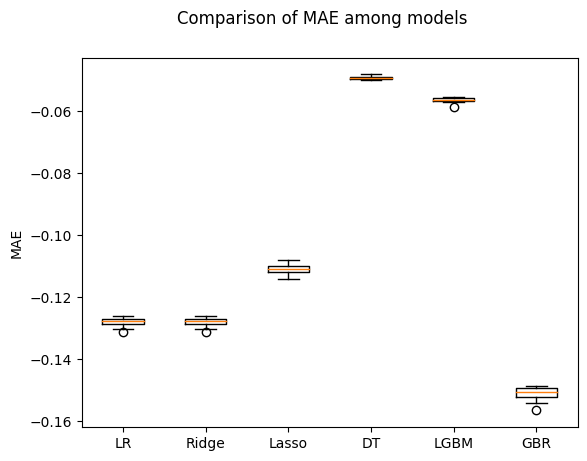

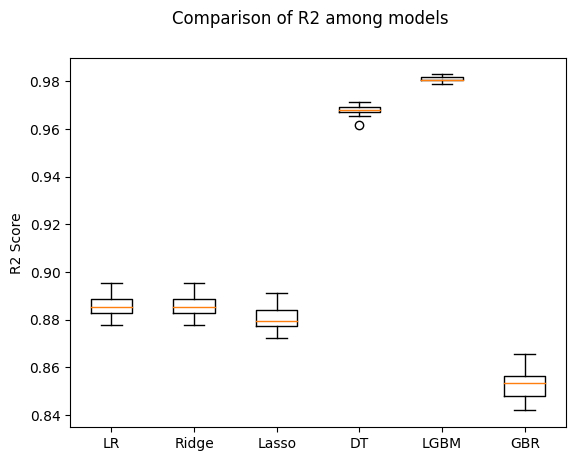

In [9]:


num_folds = 10
seed = 7
scorers = {'mae': make_scorer(mean_absolute_error), 'r2': make_scorer(r2_score)}
models = []

# Defining models
models.append(('LR', LinearRegression()))
models.append(('Ridge', Ridge(alpha=1.0)))
models.append(('Lasso', Lasso(alpha=0.1)))
models.append(('DT', DecisionTreeRegressor(random_state=42)))
models.append(('LGBM', lgb.LGBMRegressor(objective='regression', num_leaves=31, learning_rate=0.1, n_estimators=100)))
# models.append(('RF', RandomForestRegressor(n_estimators=10, random_state=42)))
models.append(('GBR', GradientBoostingRegressor(n_estimators=10, learning_rate=1.0, max_depth=1, random_state=42)))
# models.append(('SVR', SVR(kernel='rbf', C=10, gamma=0.1, epsilon=0.1)))

# Function to evaluate models
def check_model(name, model, X, y, scoring):
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    msg = f"{scoring} {name}: {cv_results.mean():.3f} ({cv_results.std():.3f})"
    print(msg)
    return cv_results

results_mae = []
names_mae = []
results_r2 = []
names_r2 = []

# Evaluating models
for name, model in models:
    print(f"Evaluating {name}...")
    mae_result = check_model(name, model, X_valid, y_valid, scoring='neg_mean_absolute_error')
    results_mae.append(mae_result)
    names_mae.append(name)
    
    r2_result = check_model(name, model,  X_valid, y_valid, scoring='r2')
    results_r2.append(r2_result)
    names_r2.append(name)

# Plotting MAE
fig_mae = plt.figure()
fig_mae.suptitle('Comparison of MAE among models')
ax_mae = fig_mae.add_subplot(111)
plt.boxplot(results_mae)
ax_mae.set_xticklabels(names_mae)
plt.ylabel('MAE')
plt.show()

# Plotting R2
fig_r2 = plt.figure()
fig_r2.suptitle('Comparison of R2 among models')
ax_r2 = fig_r2.add_subplot(111)
plt.boxplot(results_r2)
ax_r2.set_xticklabels(names_r2)
plt.ylabel('R2 Score')
plt.show()
